# Hyperparameter Optimization 

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append("../FinRL/")
sys.path.append("../")
import Config.local_config as local_config

In [3]:
import pandas as pd 
import numpy as np
import optuna
from optuna.integration import PyTorchLightningPruningCallback
import matplotlib
import matplotlib.pyplot as plt
import datetime
from pathlib import Path
import ray
from pprint import pprint
import kaleido
import joblib
import pickle
import empyrical

from IPython.display import clear_output

In [4]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances

In [5]:
from finrl import config
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.env_stock_trading.env_stocktrading_np import StockTradingEnv as StockTradingEnv_numpy
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.agents.rllib.models import DRLAgent as DRLAgent_rllib
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

In [6]:
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3 import DDPG
from stable_baselines3 import TD3
from stable_baselines3 import SAC

In [7]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

## Global Variables

In [8]:
MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}
MODEL_KWARGS = {x: config.__dict__[f"{x.upper()}_PARAMS"] for x in MODELS.keys()}

In [9]:
tpm_hist = {}
total_timesteps = 2000
tp_metric = "avgwl"
n_trials = 100

## Logging callback params
lc_threshold=1e-5
lc_patience=15
lc_trial_number=100

## Data Preparation

In [10]:
data = pd.read_csv("../Datasets/DOWIndicatorData.csv")

In [11]:
train = data_split(data, local_config.TRAIN_START_DATE, local_config.TRAIN_END_DATE)
trade = data_split(data, local_config.TRADE_START_DATE, local_config.TRADE_END_DATE)

In [12]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(data.columns[8:-2]) * stock_dimension

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": [0.001] * stock_dimension,
    "sell_cost_pct": [0.001] * stock_dimension,
    "num_stock_shares": [0] * stock_dimension,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": data.columns[8:-2], 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()
agent = DRLAgent(env = env_train)

e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs)

## Optimization

### Helper Functions

In [13]:
def calc_trade_metric(df,metric='avgwl'):
    '''# trades', '# wins', '# losses', 'wins total value', 'wins avg value',
       'losses total value', 'losses avg value'''
    # For this tutorial, the only metric available is the ratio of 
    #  average values of winning to losing trades. Others are in development.
    
    # some test cases produce no losing trades.
    # The code below assigns a value as a multiple of the highest value during
    # previous hp optimization runs. If the first run experiences no losses,
    # a fixed value is assigned for the ratio
    tpm_mult = 1.0
    avgwl_no_losses = 25
    if metric == 'avgwl':
        if sum(df['# losses']) == 0:
          try:
            return max(tpm_hist.values())*tpm_mult
          except ValueError:
            return avgwl_no_losses
        avg_w = sum(df['wins total value'])/sum(df['# wins'])
        avg_l = sum(df['losses total value'])/sum(df['# losses'])
        m = abs(avg_w/avg_l)

    return m


def prep_data(df_actions,
              df_prices_trade):
    
    df=df_prices_trade[['date','close','tic']]
    df['Date'] = pd.to_datetime(df['date'])
    df = df.set_index('Date')
    # set indices on both df to datetime
    idx = pd.to_datetime(df_actions.index, infer_datetime_format=True)
    df_actions.index=idx
    tics = np.unique(df.tic)
    n_tics = len(tics)
    print(f'Number of tickers: {n_tics}')
    print(f'Tickers: {tics}')
    dategr = df.groupby('tic')
    p_d={t:dategr.get_group(t).loc[:,'close'] for t in tics}
    df_prices = pd.DataFrame.from_dict(p_d)
    df_prices.index = df_prices.index.normalize()
    return df_actions, df_prices, tics


# prepares for integrating action and price files
def link_prices_actions(df_a,
                        df_p):
    cols_a = [t + '_a' for t in df_a.columns]
    df_a.columns = cols_a
    cols_p = [t + '_p' for t in df_p.columns]
    df_p.columns = cols_p
    return df_a, df_p


def sync_tickers(df_actions,df_tickers_p,tickers):
    # Some DOW30 components may not be included in portfolio
    # passed tickers includes all DOW30 components
    # actions and ticker files may have different length indices
    if len(df_actions) != len(df_tickers_p):
      msng_dates = set(df_actions.index)^set(df_tickers_p.index)
      try:
        #assumption is prices has one additional timestamp (row)
        df_tickers_p.drop(msng_dates,inplace=True)
      except:
        df_actions.drop(msng_dates,inplace=True)
    df_actions, df_tickers_p = link_prices_actions(df_actions,df_tickers_p)
    # identify any DOW components not in portfolio
    t_not_in_a = [t for t in tickers if t + '_a' not in list(df_actions.columns)]
  
    # remove t_not_in_a from df_tickers_p
    drop_cols = [t + '_p' for t in t_not_in_a]
    df_tickers_p.drop(columns=drop_cols,inplace=True)
    
    # Tickers in portfolio
    tickers_prtfl = [c.split('_')[0] for c in df_actions.columns]
    return df_actions,df_tickers_p, tickers_prtfl

def collect_performance_data(dfa,dfp,tics, dbg=False):
    
    perf_data = {}
    # In current version, files columns include secondary identifier
    for t in tics:
        # actions: purchase/sale of DOW equities
        acts = dfa['_'.join([t,'a'])].values
        # ticker prices
        prices = dfp['_'.join([t,'p'])].values
        # market value of purchases/sales
        tvals_init = np.multiply(acts,prices)
        d={'actions':acts, 'prices':prices,'init_values':tvals_init}
        perf_data[t]=d

    return perf_data


def calc_pnl_all(perf_dict, tics_all):
    # calculate profit/loss for each ticker
    print(f'Calculating profit/loss for each ticker')
    pnl_all = {}
    for tic in tics_all:
        pnl_t = []
        tic_data = perf_dict[tic]
        init_values = tic_data['init_values']
        acts = tic_data['actions']
        prices = tic_data['prices']
        cs = np.cumsum(acts)
        args_s = [i + 1 for i in range(len(cs) - 1) if cs[i + 1] < cs[i]]
        # tic actions with no sales
        if not args_s:
            pnl = complete_calc_buyonly(acts, prices, init_values)
            pnl_all[tic] = pnl
            continue
        # copy acts: acts_rev will be revised based on closing/reducing init positions
        pnl_all = execute_position_sales(tic,acts,prices,args_s,pnl_all)

    return pnl_all


def complete_calc_buyonly(actions, prices, init_values):
    # calculate final pnl for each ticker assuming no sales
    fnl_price = prices[-1]
    final_values = np.multiply(fnl_price, actions)
    pnl = np.subtract(final_values, init_values)
    return pnl


def execute_position_sales(tic,acts,prices,args_s,pnl_all):
  # calculate final pnl for each ticker with sales
    pnl_t = []
    acts_rev = acts.copy()
    # location of sales transactions
    for s in args_s:  # s is scaler
        # price_s = [prices[s]]
        act_s = [acts_rev[s]]
        args_b = [i for i in range(s) if acts_rev[i] > 0]
        prcs_init_trades = prices[args_b]
        acts_init_trades = acts_rev[args_b]
  
        # update actions for sales
        # reduce/eliminate init values through trades
        # always start with earliest purchase that has not been closed through sale
        # selectors for purchase and sales trades
        # find earliest remaining purchase
        arg_sel = min(args_b)
        # sel_s = len(acts_trades) - 1

        # closing part/all of earliest init trade not yet closed
        # sales actions are negative
        # in this test case, abs_val of init and sales share counts are same
        # zero-out sales actions
        # market value of sale
        # max number of shares to be closed: may be less than # originally purchased
        acts_shares = min(abs(act_s.pop()), acts_rev[arg_sel])

        # mv of shares when purchased
        mv_p = abs(acts_shares * prices[arg_sel])
        # mv of sold shares
        mv_s = abs(acts_shares * prices[s])

        # calc pnl
        pnl = mv_s - mv_p
        # reduce init share count
        # close all/part of init purchase
        acts_rev[arg_sel] -= acts_shares
        acts_rev[s] += acts_shares
        # calculate pnl for trade
        # value of associated purchase
        
        # find earliest non-zero positive act in acts_revs
        pnl_t.append(pnl)
    
    pnl_op = calc_pnl_for_open_positions(acts_rev, prices)
    #pnl_op is list
    # add pnl_op results (if any) to pnl_t (both lists)
    pnl_t.extend(pnl_op)
    #print(f'Total pnl for {tic}: {np.sum(pnl_t)}')
    pnl_all[tic] = np.array(pnl_t)
    return pnl_all


def calc_pnl_for_open_positions(acts,prices):
    # identify any positive share values after accounting for sales
    pnl = []
    fp = prices[-1] # last price
    open_pos_arg = np.argwhere(acts>0)
    if len(open_pos_arg)==0:return pnl # no open positions

    mkt_vals_open = np.multiply(acts[open_pos_arg], prices[open_pos_arg])
    # mkt val at end of testing period
    # treat as trades for purposes of calculating pnl at end of testing period
    mkt_vals_final = np.multiply(fp, acts[open_pos_arg])
    pnl_a = np.subtract(mkt_vals_final, mkt_vals_open)
    #convert to list
    pnl = [i[0] for i in pnl_a.tolist()]
    #print(f'Market value of open positions at end of testing {pnl}')
    return pnl


def calc_trade_perf(pnl_d):
    # calculate trade performance metrics
    perf_results = {}
    for t,pnl in pnl_d.items():
        wins = pnl[pnl>0]  # total val
        losses = pnl[pnl<0]
        n_wins = len(wins)
        n_losses = len(losses)
        n_trades = n_wins + n_losses
        wins_val = np.sum(wins)
        losses_val = np.sum(losses)
        wins_avg = 0 if n_wins==0 else np.mean(wins)
        #print(f'{t} n_wins: {n_wins} n_losses: {n_losses}')
        losses_avg = 0 if n_losses==0 else np.mean(losses)
        d = {'# trades':n_trades,'# wins':n_wins,'# losses':n_losses,
             'wins total value':wins_val, 'wins avg value':wins_avg,
             'losses total value':losses_val, 'losses avg value':losses_avg,}
        perf_results[t] = d
    return perf_results

In [14]:
def calc_trade_perf_metric(df_actions, df_prices_trade, tp_metric, dbg=False):
    df_actions_p, df_prices_p, tics = prep_data(df_actions.copy(),
                                                df_prices_trade.copy())
    
    df_actions_s, df_prices_s, tics_prtf1 = sync_tickers(df_actions_p.copy(), df_prices_p.copy(),tics)

    # Confirms that actions, prices and tics are consistent
    df_actions_s, df_prices_s, tics_prtfl = \
        sync_tickers(df_actions_p.copy(),df_prices_p.copy(),tics)
    
    # copy to ensure that tics from portfolio remains unchanged
    tics = tics_prtfl.copy()
    
    # Analysis is performed on each portfolio ticker
    perf_data= collect_performance_data(df_actions_s, df_prices_s, tics)
    # profit/loss for each ticker
    pnl_all = calc_pnl_all(perf_data, tics)
    # values for trade performance metrics
    perf_results = calc_trade_perf(pnl_all)
    df = pd.DataFrame.from_dict(perf_results, orient='index')
    
    # calculate and return trade metric value as objective
    m = calc_trade_metric(df,tp_metric)
    print(f'Ratio Avg Win/Avg Loss: {m}')
    k = str(len(tpm_hist)+1)
    # save metric value
    tpm_hist[k] = m
    return m



### Samplers

In [15]:
def A2C_sampler(trial:optuna.Trial):
    gamma = trial.suggest_categorical(
        "gamma", [0.9, 0.95, 0.98, 0.99, 0.995, 0.999, 0.9999]
    )

    normalize_advantage = trial.suggest_categorical(
        "normalize_advantage", [False, True]
    )

    max_grad_norm = trial.suggest_categorical(
        "max_grad_norm", [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 5]
    )

    use_rms_prop = trial.suggest_categorical(
        "use_rms_prop", [False, True]
    )
    
    gae_lambda = trial.suggest_categorical(
        "gae_lambda", [0.8, 0.9, 0.92, 0.95, 0.98, 0.99, 1.0]
    )

    n_steps = trial.suggest_categorical(
        "n_steps", [5, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
    )

    learning_rate = trial.suggest_loguniform(
        "learning_rate", 1e-5, 1
    )

    ent_coef = trial.suggest_loguniform(
        "ent_coef", 0.00000001, 0.1
    )

    vf_coef = trial.suggest_uniform(
        "vf_coef", 0, 1
    )

    hyperparams = {
        "n_steps": n_steps,
        "gamma": gamma,
        "gae_lambda": gae_lambda,
        "learning_rate": learning_rate,
        "ent_coef": ent_coef,
        "normalize_advantage": normalize_advantage,
        "max_grad_norm": max_grad_norm,
        "use_rms_prop": use_rms_prop,
        "vf_coef": vf_coef,
    }

    return hyperparams

In [16]:
def PPO_sampler(trial:optuna.Trial):
    gamma = trial.suggest_categorical(
        "gamma", [0.9, 0.95, 0.98, 0.99, 0.995, 0.999, 0.9999]
    )

    batch_size = trial.suggest_categorical(
        "batch_size", [8, 16, 32, 64, 128, 256, 512]
    )

    n_steps = trial.suggest_categorical(
        "n_steps", [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
    )

    learning_rate = trial.suggest_loguniform(
        "learning_rate", 1e-5, 1
    )

    ent_coef = trial.suggest_loguniform(
        "ent_coef", 0.00000001, 0.1
    )

    clip_range = trial.suggest_categorical(
        "clip_range", [0.1, 0.2, 0.3, 0.4]
    )

    n_epochs = trial.suggest_categorical(
        "n_epochs", [1, 5, 10, 20]
    )

    gae_lambda = trial.suggest_categorical(
        "gae_lambda", [0.8, 0.9, 0.92, 0.95, 0.98, 0.99, 1.0]
    )

    max_grad_norm = trial.suggest_categorical(
        "max_grad_norm", [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 5]
    )

    vf_coef = trial.suggest_uniform(
        "vf_coef", 0, 1
    )

    hyperparams = {
        "n_steps": n_steps,
        "batch_size": batch_size,
        "gamma": gamma,
        "learning_rate": learning_rate,
        "ent_coef": ent_coef,
        "clip_range": clip_range,
        "n_epochs": n_epochs,
        "gae_lambda": gae_lambda,
        "max_grad_norm": max_grad_norm,
        "vf_coef": vf_coef,
    }

    return hyperparams 

In [17]:
def DDPG_sampler(trial:optuna.Trial):
    gamma = trial.suggest_categorical(
        "gamma", [0.9, 0.95, 0.98, 0.99, 0.995, 0.999, 0.9999]
    )

    noise_type = trial.suggest_categorical(
        "noise_type", ["ornstein_uhlenbeck", "normal"]
    )

    batch_size = trial.suggest_categorical(
        "batch_size", [16, 32, 64, 100, 128, 256, 512, 1024, 2048]
    )

    buffer_size = trial.suggest_categorical(
        "buffer_size", [50000, int(1e4), int(1e5), int(1e6)]
    )

    train_freq = trial.suggest_categorical(
        "train_freq", [1, 4, 8, 16, 32, 64, 128, 256, 512]
    )

    tau = trial.suggest_categorical(
        "tau", [0.001, 0.005, 0.01, 0.02, 0.05, 0.08]
    )
    
    learning_rate = trial.suggest_loguniform(
        "learning_rate", 1e-5, 1
    )

    hyperparams = {
        "gamma": gamma,
        "tau": tau,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "buffer_size": buffer_size,
        "train_freq": train_freq,
        "gradient_steps": train_freq,
        "action_noise": noise_type
    }
    return hyperparams
    

In [18]:
MODEL_KWARGS["ddpg"]

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}

In [19]:
def TD3_sampler(trial:optuna.Trial):
    gamma = trial.suggest_categorical(
        "gamma", [0.9, 0.95, 0.98, 0.99, 0.995, 0.999, 0.9999]
    )

    learning_rate = trial.suggest_loguniform(
        "learning_rate", 1e-5, 1
    )

    batch_size = trial.suggest_categorical(
        "batch_size", [16, 32, 64, 100, 128, 256, 512, 1024, 2048]
    )

    buffer_size = trial.suggest_categorical(
        "buffer_size", [int(1e4), int(1e5), int(1e6)]
    )

    tau = trial.suggest_categorical(
        "tau", [0.001, 0.005, 0.01, 0.02, 0.05, 0.08]
    )

    train_freq = trial.suggest_categorical(
        "train_freq", [1, 4, 8, 16, 32, 64, 128, 256, 512]
    )

    noise_type = trial.suggest_categorical(
        "noise_type", ["ornstein_uhlenbeck", "normal"]
    )

    hyperparams = {
        "gamma": gamma,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "buffer_size": buffer_size,
        "train_freq": train_freq,
        "gradient_steps": train_freq,
        "tau": tau,
        "action_noise": noise_type
    }

    return hyperparams

In [20]:
def SAC_sampler(trial:optuna.Trial):
    gamma = trial.suggest_categorical(
        "gamma", [0.9, 0.95, 0.98, 0.99, 0.995, 0.999, 0.9999]
    )

    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1)

    batch_size = trial.suggest_categorical(
        "batch_size", [16, 32, 64, 128, 256, 512, 1024, 2048]
    )

    buffer_size = trial.suggest_categorical(
        "buffer_size", [int(1e4), int(1e5), int(1e6)]
    )

    learning_starts = trial.suggest_categorical(
        "learning_starts", [0, 100, 1000, 10000, 20000]
    )

    train_freq = trial.suggest_categorical(
        "train_freq", [1, 4, 8, 16, 32, 64, 128, 256, 512]
    )

    tau = trial.suggest_categorical(
        "tau", [0.001, 0.005, 0.01, 0.02, 0.05, 0.08]
    )

    hyperparams = {
        "gamma": gamma,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "buffer_size": buffer_size,
        "learning_starts": learning_starts,
        "train_freq": train_freq,
        "gradient_steps": train_freq,
        "ent_coef": "auto",
        "tau": tau,
        "target_entropy": "auto",
    }

    return hyperparams

### Objectives 

In [21]:
def A2C_objective(trial:optuna.Trial):
    hyperparameters = A2C_sampler(trial)
    policy_kwargs = None

    A2C_model = agent.get_model("a2c",
                                 policy_kwargs=policy_kwargs,
                                 model_kwargs=hyperparameters)
    A2C_trained = agent.train_model(model = A2C_model,
                                     tb_log_name = "A2C",
                                     total_timesteps = total_timesteps)
    
    A2C_trained.save('trained_models/A2C/trial_{}.pth'.format(trial.number))

    clear_output(wait = True)
    df_account_value, df_actions = DRLAgent.DRL_prediction(
        model = A2C_trained,
        environment = e_trade_gym
    )
    tmp = calc_trade_perf_metric(df_actions, trade, tp_metric)
    
    df_account_value["date"] = pd.to_datetime(df_account_value["date"])
    bt_returns = get_daily_return(df_account_value, value_col_name="account_value")
    sharpe = empyrical.sharpe_ratio(bt_returns)

    return tmp, float(sharpe)

In [22]:
def PPO_objective(trial:optuna.Trial):
    hyperparameters = PPO_sampler(trial)
    policy_kwargs = None

    PPO_model = agent.get_model("ppo",
                                 policy_kwargs=policy_kwargs,
                                 model_kwargs=hyperparameters)
    PPO_trained = agent.train_model(model = PPO_model,
                                     tb_log_name = "PPO",
                                     total_timesteps = total_timesteps)
    
    PPO_trained.save('trained_models/PPO/trial_{}.pth'.format(trial.number))

    clear_output(wait = True)
    df_account_value, df_actions = DRLAgent.DRL_prediction(
        model = PPO_trained,
        environment = e_trade_gym
    )
    tmp = calc_trade_perf_metric(df_actions, trade, tp_metric)
    
    df_account_value["date"] = pd.to_datetime(df_account_value["date"])
    bt_returns = get_daily_return(df_account_value, value_col_name="account_value")
    sharpe = empyrical.sharpe_ratio(bt_returns)

    return tmp, float(sharpe)

In [23]:
def ddpg_objective(trial:optuna.Trial):
    hyperparameters = DDPG_sampler(trial)
    policy_kwargs = None

    DDPG_model = agent.get_model("ddpg",
                                 policy_kwargs=policy_kwargs,
                                 model_kwargs=hyperparameters)
    DDPG_trained = agent.train_model(model = DDPG_model,
                                     tb_log_name = "ddpg",
                                     total_timesteps = total_timesteps)

    DDPG_trained.save('trained_models/ddpg/trial_{}.pth'.format(trial.number))

    clear_output(wait = True)
    df_account_value, df_actions = DRLAgent.DRL_prediction(
        model = DDPG_trained,
        environment = e_trade_gym
    )
    tmp = calc_trade_perf_metric(df_actions, trade, tp_metric)

    df_account_value["date"] = pd.to_datetime(df_account_value["date"])
    bt_returns = get_daily_return(df_account_value, value_col_name="account_value")
    sharpe = empyrical.sharpe_ratio(bt_returns)
    print(tmp, float(sharpe))
    return tmp, float(sharpe)

In [24]:
def TD3_objective(trial:optuna.Trial):
    hyperparameters = TD3_sampler(trial)
    policy_kwargs = None

    TD3_model = agent.get_model("td3",
                                 policy_kwargs=policy_kwargs,
                                 model_kwargs=hyperparameters)
    TD3_trained = agent.train_model(model = TD3_model,
                                     tb_log_name = "TD3",
                                     total_timesteps = total_timesteps)

    TD3_trained.save('trained_models/TD3/trial_{}.pth'.format(trial.number))

    clear_output(wait = True)
    df_account_value, df_actions = DRLAgent.DRL_prediction(
        model = TD3_trained,
        environment = e_trade_gym
    )
    tmp = calc_trade_perf_metric(df_actions, trade, tp_metric)
    
    df_account_value["date"] = pd.to_datetime(df_account_value["date"])
    bt_returns = get_daily_return(df_account_value, value_col_name="account_value")
    sharpe = empyrical.sharpe_ratio(bt_returns)

    return tmp, float(sharpe)

In [25]:
def SAC_objective(trial:optuna.Trial):
    hyperparameters = SAC_sampler(trial)
    policy_kwargs = None

    SAC_model = agent.get_model("sac",
                                 policy_kwargs=policy_kwargs,
                                 model_kwargs=hyperparameters)
    SAC_trained = agent.train_model(model = SAC_model,
                                     tb_log_name = "SAC",
                                     total_timesteps = total_timesteps)

    SAC_trained.save('trained_models/SAC/trial_{}.pth'.format(trial.number))

    clear_output(wait = True)
    df_account_value, df_actions = DRLAgent.DRL_prediction(
        model = SAC_trained,
        environment = e_trade_gym
    )
    tmp = calc_trade_perf_metric(df_actions, trade, tp_metric)
    
    df_account_value["date"] = pd.to_datetime(df_account_value["date"])
    bt_returns = get_daily_return(df_account_value, value_col_name="account_value")
    sharpe = empyrical.sharpe_ratio(bt_returns)

    return tmp, float(sharpe)

## Running Optimization

In [26]:
class LoggingCallback:
    def __init__(self,threshold,trial_number,patience):
      '''
      threshold:int tolerance for increase in objective
      trial_number: int Prune after minimum number of trials
      patience: int patience for the threshold
      '''
      self.threshold = threshold
      self.trial_number  = trial_number
      self.patience = patience
      print(f'Callback threshold {self.threshold}, \
            trial_number {self.trial_number}, \
            patience {self.patience}')
      self.cb_list = [] #Trials list for which threshold is reached
    
    def __call__(self,study:optuna.study, frozen_trial:optuna.Trial):
      #Setting the best value in the current trial
      print(study.best_trials)
      study.set_user_attr("previous_best_value", max(study.best_trials, key=lambda t: t.values[1]).values)
      
      #Checking if the minimum number of trials have pass
      if frozen_trial.number >self.trial_number:
          previous_best_value = study.user_attrs.get("previous_best_value",None)
          #Checking if the previous and current objective values have the same sign
          if previous_best_value * max(study.best_trials, key=lambda t: t.values[1]).values >=0:
              #Checking for the threshold condition
              if abs(previous_best_value-max(study.best_trials, key=lambda t: t.values[1]).values) < self.threshold:  
                  self.cb_list.append(frozen_trial.number)
                  #If threshold is achieved for the patience amount of time
                  if len(self.cb_list)>self.patience:
                      print('The study stops now...')
                      print('With number',frozen_trial.number ,'and value ',frozen_trial.value)
                      print('The previous and current best values are {} and {} respectively'
                              .format(previous_best_value, max(study.best_trials, key=lambda t: t.values[1]).values))
                      study.stop()

In [27]:
def study(alg_name, objective, initial_params):
    sampler = optuna.samplers.TPESampler()
    study_name = alg_name + "_study"
    study = optuna.create_study(
        study_name = study_name,
        directions = ["maximize", "maximize"],
        sampler = sampler,
        pruner = optuna.pruners.HyperbandPruner()
    )

    logging_callback = LoggingCallback(
        threshold = lc_threshold,
        patience = lc_patience,
        trial_number = lc_trial_number
    )

    study.enqueue_trial(initial_params)

    study.optimize(
        objective, 
        n_trials = n_trials, 
        catch = (ValueError,),
        callbacks = [logging_callback]
    )

    joblib.dump(study, ("studies/" + study_name +".pkl"))

    return study

In [28]:
def add_trade_perf_metric(df_actions, perf_stats_all, trade, tp_metric):
        tpm = calc_trade_perf_metric(df_actions,trade,tp_metric)
        trp_metric = {'Value':tpm}
        df2 = pd.DataFrame(trp_metric,index=['Trade_Perf'])
        perf_stats_all = perf_stats_all.append(df2)
        return perf_stats_all

def backtesting(studyIn, alg_name, model):
    best_p1 = max(studyIn.best_trials, key=lambda t: t.values[0])
    best_p2 = max(studyIn.best_trials, key=lambda t: t.values[1])
    dist_p1 = abs(best_p1.values[0] - best_p2.values[0])
    dist_p2 = abs(best_p1.values[1] - best_p2.values[1])

    if dist_p1 < dist_p2:
        key_value = 1
    else:
        key_value = 0

    tuned_model = model.load('trained_models/{}/trial_{}.pth'.format(alg_name, max(studyIn.best_trials, key=lambda t: t.values[key_value]).number,env=env_train))

    df_account_value_tuned, df_actions_tuned = DRLAgent.DRL_prediction(
        model=tuned_model, 
        environment = e_trade_gym)

    now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
    df_actions_tuned.to_csv("./"+config.RESULTS_DIR+"/" + alg_name + "/tuned_actions_" +now+ '.csv')

    #Backtesting with our pruned model
    print("==============Get Backtest Results===========")
    print("==============Pruned Model===========")
    now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

    perf_stats_all_tuned = backtest_stats(account_value=df_account_value_tuned)
    perf_stats_all_tuned = pd.DataFrame(perf_stats_all_tuned)
    perf_stats_all_tuned.columns = ['Value']
    # add trade performance metric
    perf_stats_all_tuned = \
    add_trade_perf_metric(df_actions_tuned,
                            perf_stats_all_tuned,
                            trade,
                            tp_metric)
    perf_stats_all_tuned.to_csv("./"+config.RESULTS_DIR+"/" + alg_name + "/perf_stats_all_tuned_"+now+'.csv')


In [29]:
def parameter_importance(studyIn, alg_name):
    fig = plot_optimization_history(studyIn, target = lambda t: t.values[0])
    fig.write_image("./"+config.RESULTS_DIR+"/" + alg_name + "/opt_hist.png")
    fig.show()

    try:
        fig = plot_param_importances(studyIn, target = lambda t: t.values[0])
        fig.write_image("./"+config.RESULTS_DIR+"/" + alg_name + "/params_importances.png")
        fig.show()
    except:
        print('Cannot calculate hyperparameter importances: no variation')
    
    fig = plot_edf(studyIn, target = lambda t: t.values[0])
    fig.write_image("./"+config.RESULTS_DIR+"/" + alg_name + "/emp_dist_func.png")
    fig.show()

### PPO

In [ ]:
PPO_study = study("PPO", PPO_objective, MODEL_KWARGS["ppo"])

In [34]:
best_p1 = max(PPO_study.best_trials, key=lambda t: t.values[0])
best_p2 = max(PPO_study.best_trials, key=lambda t: t.values[1])
print("Best 1")
print(best_p1.values)
print(best_p1.params)

print("\nBest 2")
print(best_p2.values)
print(best_p2.params)

Best 1
[9.787944951740883, 0.8789100186646955]
{'gamma': 0.95, 'batch_size': 256, 'n_steps': 8, 'learning_rate': 0.00021018657037434564, 'ent_coef': 0.004309815589442596, 'clip_range': 0.4, 'n_epochs': 1, 'gae_lambda': 0.8, 'max_grad_norm': 0.8, 'vf_coef': 0.6409605386015353}

Best 2
[6.155813803435099, 1.3351794127459038]
{'gamma': 0.999, 'batch_size': 64, 'n_steps': 256, 'learning_rate': 0.00019772244528543627, 'ent_coef': 0.0026516335854156565, 'clip_range': 0.4, 'n_epochs': 1, 'gae_lambda': 1.0, 'max_grad_norm': 0.8, 'vf_coef': 0.6537800811930741}


In [33]:
PPO_study = joblib.load(f"studies/PPO_study.pkl")

#### Backtesting

In [51]:
backtesting(PPO_study, "PPO", PPO)

hit end!
==============Get Backtest Results===========
==============Pruned Model===========
Annual return          0.148018
Cumulative returns     0.148018
Annual volatility      0.175271
Sharpe ratio           0.878910
Calmar ratio           1.128898
Stability              0.500393
Max drawdown          -0.131117
Omega ratio            1.179372
Sortino ratio          1.162600
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.914419
Daily value at risk   -0.021471
dtype: float64
Number of tickers: 29
Tickers: ['AAPL' 'AMGN' 'AXP' 'BA' 'CAT' 'CRM' 'CSCO' 'CVX' 'DIS' 'GS' 'HD' 'HON'
 'IBM' 'INTC' 'JNJ' 'JPM' 'KO' 'MCD' 'MMM' 'MRK' 'MSFT' 'NKE' 'PG' 'TRV'
 'UNH' 'V' 'VZ' 'WBA' 'WMT']
Calculating profit/loss for each ticker
Ratio Avg Win/Avg Loss: 9.787944951740883


#### Parameter Importance

In [52]:
parameter_importance(PPO_study, "PPO")

### A2C

In [ ]:
A2C_study = study("A2C", A2C_objective, MODEL_KWARGS["a2c"])

In [71]:
best_p1 = max(A2C_study.best_trials, key=lambda t: t.values[0])
best_p2 = max(A2C_study.best_trials, key=lambda t: t.values[1])
print("Best 1")
print(best_p1.values)
print(best_p1.params)

print("\nBest 2")
print(best_p2.values)
print(best_p2.params)

Best 1
[6.485703554930495, 0.8655974982883398]
{'gamma': 0.9999, 'normalize_advantage': False, 'max_grad_norm': 1, 'use_rms_prop': True, 'gae_lambda': 0.95, 'n_steps': 128, 'learning_rate': 0.0001786962050742157, 'ent_coef': 0.0006382316320313579, 'vf_coef': 0.5715030411102626}

Best 2
[5.624934213022882, 1.4364127107600253]
{'gamma': 0.9, 'normalize_advantage': True, 'max_grad_norm': 0.5, 'use_rms_prop': True, 'gae_lambda': 0.9, 'n_steps': 256, 'learning_rate': 2.2100891456797895e-05, 'ent_coef': 4.412529222975179e-08, 'vf_coef': 0.378021955021417}


In [34]:
A2C_study = joblib.load(f"studies/A2C_study.pkl")

#### Backtesting

In [ ]:
backtesting(A2C_study, "A2C", A2C)

#### Parameter Importance 

In [36]:
parameter_importance(A2C_study, "A2C")

### DDPG


In [ ]:
DDPG_study = study("ddpg", ddpg_objective, MODEL_KWARGS["ddpg"])

In [ ]:
best_p1 = max(DDPG_study.best_trials, key=lambda t: t.values[0])
best_p2 = max(DDPG_study.best_trials, key=lambda t: t.values[1])
print("Best 1")
print(best_p1.values)
print(best_p1.params)

print("\nBest 2")
print(best_p2.values)
print(best_p2.params)

DDPG_study = joblib.load(f"studies/DDPG_study.pkl")

#### Backtesting


In [ ]:
backtesting(DDPG_study, "DDPG", DDPG)

#### Parameter Importance

In [ ]:
parameter_importance(DDPG_study, "DDPG")

### TD3

In [ ]:
TD3_study = study("TD3", TD3_objective, MODEL_KWARGS["td3"])

In [31]:
best_p1 = max(TD3_study.best_trials, key=lambda t: t.values[0])
best_p2 = max(TD3_study.best_trials, key=lambda t: t.values[1])
print("Best 1")
print(best_p1.values)
print(best_p1.params)

print("\nBest 2")
print(best_p2.values)
print(best_p2.params)

Best 1
[3.2133554829769526, 0.5039628453074887]
{'gamma': 0.98, 'learning_rate': 0.0005436971782836078, 'batch_size': 2048, 'buffer_size': 10000, 'tau': 0.005, 'train_freq': 128, 'noise_type': 'ornstein_uhlenbeck'}

Best 2
[3.16303046556772, 0.7015356895232693]
{'gamma': 0.98, 'learning_rate': 0.010268730566724135, 'batch_size': 2048, 'buffer_size': 10000, 'tau': 0.005, 'train_freq': 128, 'noise_type': 'ornstein_uhlenbeck'}


In [32]:
TD3_study = joblib.load(f"studies/TD3_study.pkl")

#### Backtesting

In [33]:
backtesting(TD3_study, "TD3", TD3)

hit end!
==============Get Backtest Results===========
==============Pruned Model===========
Annual return          0.156125
Cumulative returns     0.156125
Annual volatility      0.254147
Sharpe ratio           0.701536
Calmar ratio           0.644612
Stability              0.440675
Max drawdown          -0.242199
Omega ratio            1.142691
Sortino ratio          0.928906
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.797201
Daily value at risk   -0.031312
dtype: float64
Number of tickers: 29
Tickers: ['AAPL' 'AMGN' 'AXP' 'BA' 'CAT' 'CRM' 'CSCO' 'CVX' 'DIS' 'GS' 'HD' 'HON'
 'IBM' 'INTC' 'JNJ' 'JPM' 'KO' 'MCD' 'MMM' 'MRK' 'MSFT' 'NKE' 'PG' 'TRV'
 'UNH' 'V' 'VZ' 'WBA' 'WMT']
Calculating profit/loss for each ticker
Ratio Avg Win/Avg Loss: 3.16303046556772


#### Parameter Importance


In [34]:
parameter_importance(TD3_study, "TD3")

### SAC

In [ ]:
SAC_study = study("SAC", SAC_objective, MODEL_KWARGS["sac"])

In [43]:
best_p1 = max(SAC_study.best_trials, key=lambda t: t.values[0])
best_p2 = max(SAC_study.best_trials, key=lambda t: t.values[1])
print("Best 1")
print(best_p1.values)
print(best_p1.params)

print("\nBest 2")
print(best_p2.values)
print(best_p2.params)

Best 1
[3.3688403199037875, 0.6845891896847077]
{'gamma': 0.9999, 'learning_rate': 4.730384117407402e-05, 'batch_size': 256, 'buffer_size': 1000000, 'learning_starts': 0, 'train_freq': 1, 'tau': 0.001}

Best 2
[3.3631561781035932, 0.9158800796890904]
{'gamma': 0.9999, 'learning_rate': 2.4623979562274185e-05, 'batch_size': 256, 'buffer_size': 1000000, 'learning_starts': 0, 'train_freq': 1, 'tau': 0.001}


In [44]:
SAC_study = joblib.load(f"studies/SAC_study.pkl")

#### Backtesting

In [45]:
backtesting(SAC_study, "SAC", SAC)

hit end!
==============Get Backtest Results===========
==============Pruned Model===========
Annual return          0.162940
Cumulative returns     0.162940
Annual volatility      0.278260
Sharpe ratio           0.684589
Calmar ratio           0.643621
Stability              0.512343
Max drawdown          -0.253162
Omega ratio            1.141160
Sortino ratio          0.946137
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.868395
Daily value at risk   -0.034302
dtype: float64
Number of tickers: 29
Tickers: ['AAPL' 'AMGN' 'AXP' 'BA' 'CAT' 'CRM' 'CSCO' 'CVX' 'DIS' 'GS' 'HD' 'HON'
 'IBM' 'INTC' 'JNJ' 'JPM' 'KO' 'MCD' 'MMM' 'MRK' 'MSFT' 'NKE' 'PG' 'TRV'
 'UNH' 'V' 'VZ' 'WBA' 'WMT']
Calculating profit/loss for each ticker
Ratio Avg Win/Avg Loss: 3.3688403199037875


#### Parameter Importance

In [46]:
parameter_importance(SAC_study, "SAC")

## Evaluation 

In [74]:
from copy import deepcopy
import empyrical as ep
plt.rcParams.update({'font.size': 16})

In [75]:
def train_base_model(model_name):
    model = agent.get_model(model_name, 
                            policy_kwargs=None,
                            model_kwargs=MODEL_KWARGS[model_name])
    trained_model = agent.train_model(model = model,
                                      tb_log_name = f"{model_name}_base",
                                      total_timesteps = total_timesteps)
    
    df_account_value_base, df_actions_base = DRLAgent.DRL_prediction(
        model=trained_model, 
        environment = e_trade_gym)
    
    return df_account_value_base

def convert_bt_returns(account_value):
    df = deepcopy(account_value)
    df["date"] = pd.to_datetime(df["date"])
    return get_daily_return(df, value_col_name="account_value")


In [76]:
def plot_models(model_name, model):
    study = joblib.load(f"studies/{model_name.upper()}_study.pkl")

    best_p1 = max(study.best_trials, key=lambda t: t.values[0])
    best_p2 = max(study.best_trials, key=lambda t: t.values[1])
    dist_p1 = abs(best_p1.values[0] - best_p2.values[0])
    dist_p2 = abs(best_p1.values[1] - best_p2.values[1])

    if dist_p1 < dist_p2:
        key_value = 1
    else:
        key_value = 0

    tuned_model = model.load('trained_models/{}/trial_{}.pth'.format(model_name, max(study.best_trials, key=lambda t: t.values[key_value]).number,env=env_train))

    df_account_value_tuned, df_actions_tuned = DRLAgent.DRL_prediction(
        model=tuned_model, 
        environment = e_trade_gym)

    base_model_account_value = train_base_model(model_name)
    bt_returns_tuned = convert_bt_returns(df_account_value_tuned)
    bt_returns_base = convert_bt_returns(base_model_account_value)

    %matplotlib inline
    plt.rcParams["figure.figsize"] = (16,8)
    

    cum_rets_tuned = ep.cum_returns(bt_returns_tuned, 1.0)
    plt.plot(cum_rets_tuned.index, cum_rets_tuned.values, color = "Blue", label = "Tuned")

    cum_rets_base = ep.cum_returns(bt_returns_base, 1.0)
    plt.plot(cum_rets_base.index, cum_rets_base.values, color = "Red", label = "Base")

    plt.legend()
    plt.title(f"Comparison Between Tuned and Base {model_name.upper()} Models")
    plt.grid()
    plt.show()

### Example Improvements

hit end!
{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
hit end!


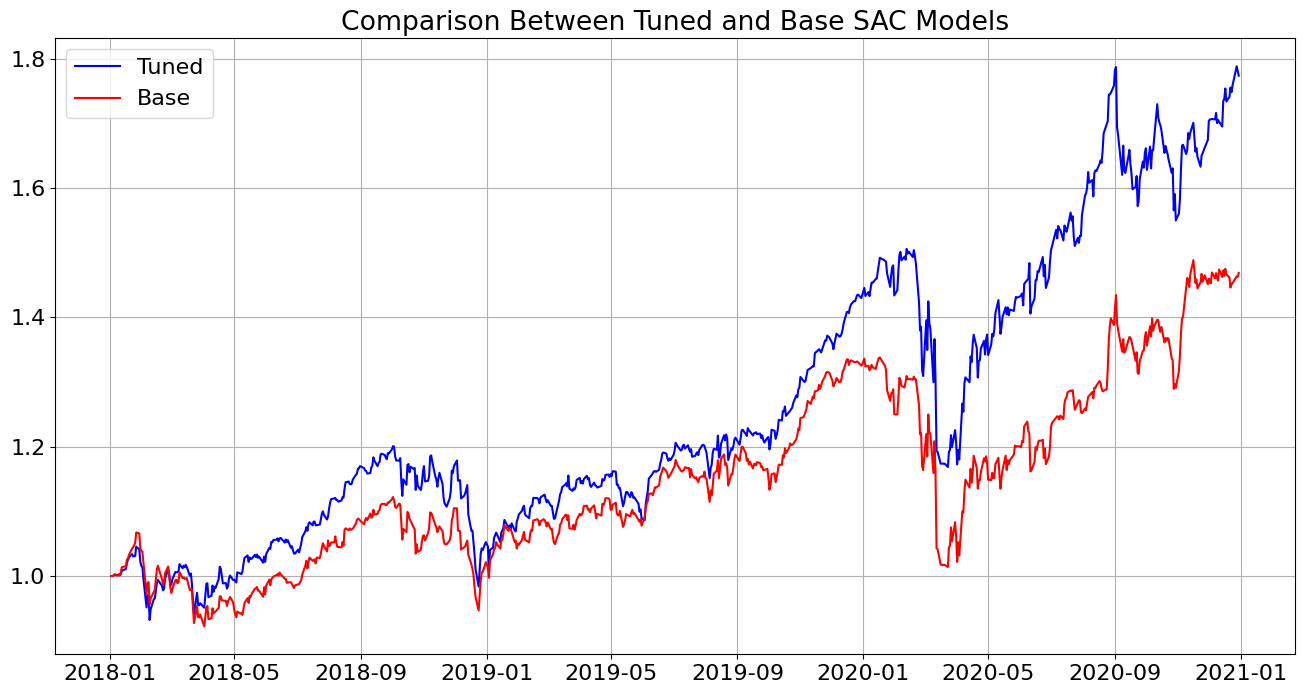

In [78]:
plot_models("sac", SAC)

day: 754, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 1415768.44
total_reward: 415768.44
total_cost: 3386.75
total_trades: 5244
Sharpe: 0.734
hit end!
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
----------------------------------
| time/              |           |
|    fps             | 102       |
|    iterations      | 1         |
|    time_elapsed    | 19        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.2880637 |
----------------------------------
hit end!


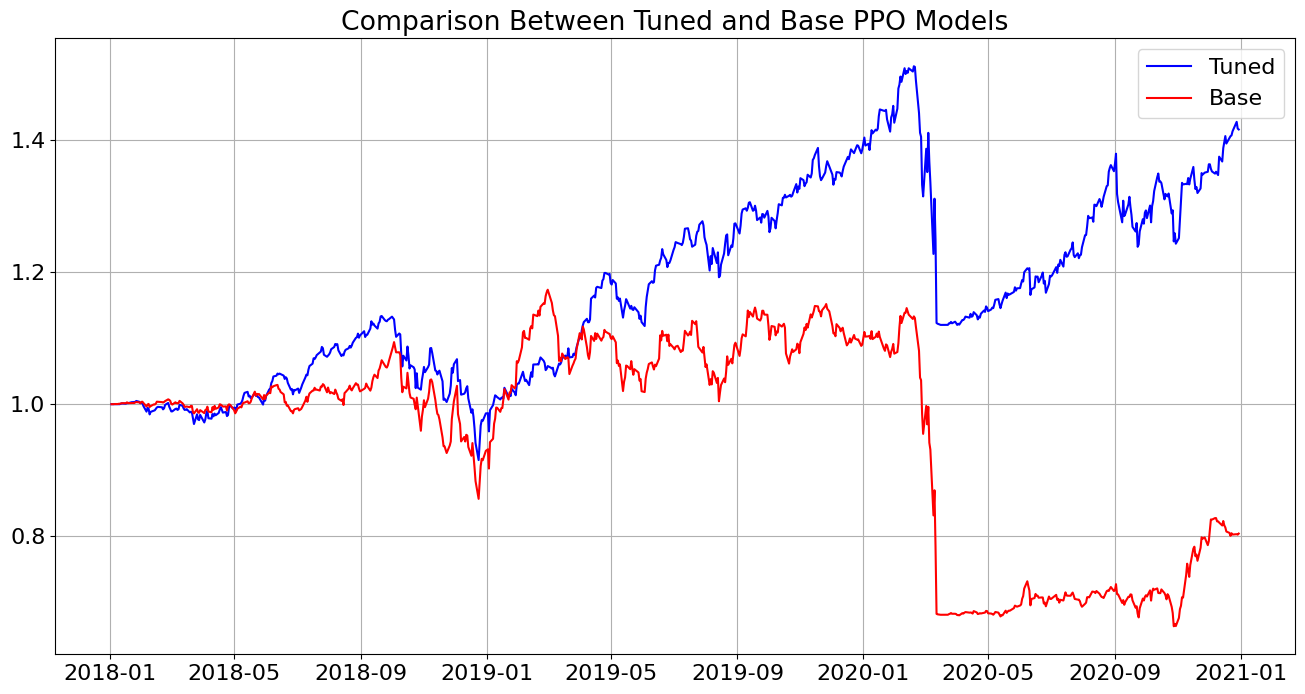

In [77]:
plot_models("ppo", PPO)

hit end!
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
hit end!


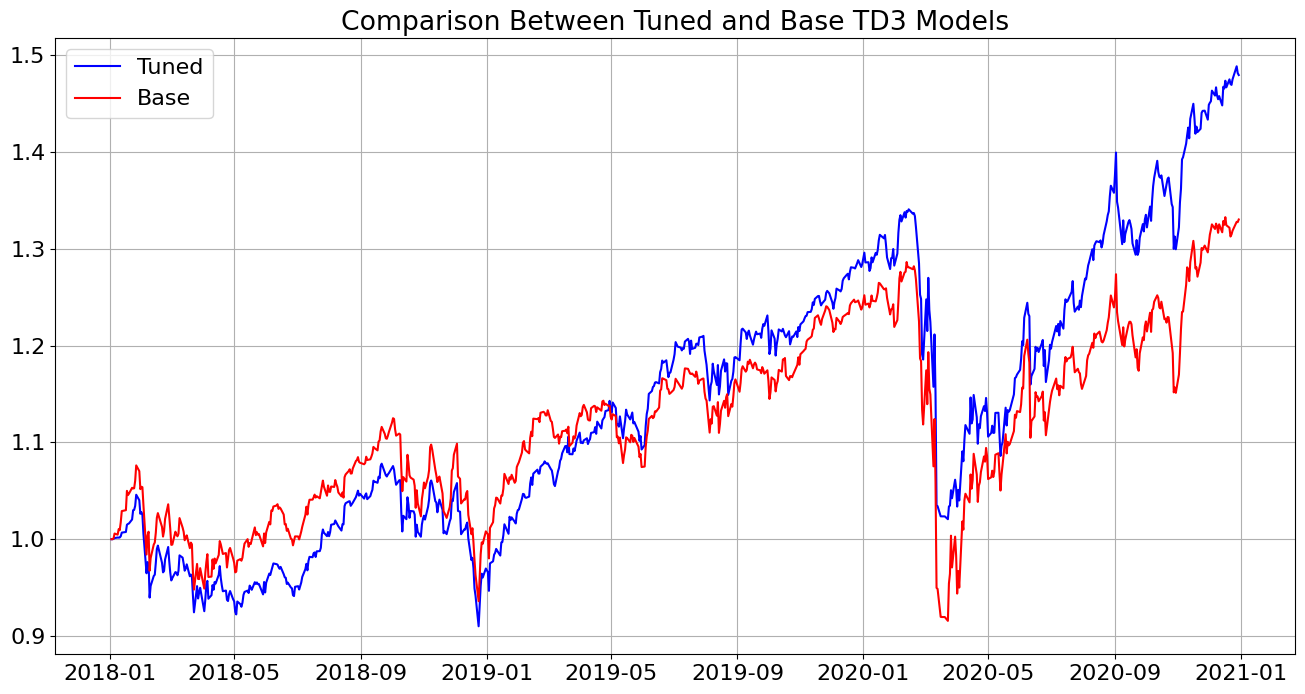

In [79]:
plot_models("td3", TD3)